In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import trains_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data = load_boston()
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [2]:
X, y = data["data"], data["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = Pipeline([('std_scl',StandardScaler())])

X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

In [4]:
from sklearn.base import clone
import time

# we can make this more rebust my making everything keyword arguments and returning 
# if our estimator, X, or y input is not set and having default parameters for everything else to use if we include
# more parameters

def customCrossValidate(estimator, X, y, cv=5, pipeline=None):
    data = {"train_score":[],
            "test_score":[],
            "fit_time":[],
            'estimator':[]
           }
    
    for _ in range(cv):
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        
        if pipeline is not None:
            pipeline_clone = clone(pipeline)
            X_train = pipeline_clone.fit_transform(X_train)
            X_val = pipeline_clone.transform(X_val)
            
        # create unfitted estimator with same parameters
        estimator_clone = clone(estimator)
        start = time.time()
        estimator_clone.fit(X_train, y_train)
        
        data['fit_time'].append(time.time()-start)
        data['train_score'].append(estimator_clone.score(X_train, y_train))
        data['test_score'].append(estimator_clone.score(X_val, y_val))
        data['estimator'].append(estimator_clone)
        
    return data

In [5]:
def plotCVResults(cv_res, names):
    fig = plt.figure(figsize=(20,10))
    trainin_time_ax = fig.add_subplot(2,1,2)
    for i in range(4):
        name = names[i]
        df_reg = pd.DataFrame(cv_res[i])

        ax = fig.add_subplot(2,4,i+1)

        ax.set_title(name + " scores, adj. avg test: " + \
                     str(round(df_reg.loc[df_reg["test_score"]>0]["test_score"].mean(),2)))
        ax.set_xlabel("iteration")
        ax.set_ylabel("R2 score")
        ax.set_ylim(0,1)
        df_reg[["train_score","test_score"]].plot(ax=ax)

        df_reg["fit_time"].plot(ax=trainin_time_ax,label=name)

    plt.sca(trainin_time_ax)
    plt.legend()
    plt.show()

In [6]:
from sklearn.neighbors import KNeighborsRegressor

cv_res = []
for n_neighbors in range(1,17,5):
    cv_res.append(customCrossValidate(KNeighborsRegressor(n_neighbors=n_neighbors,
                                                          weights='uniform'),
                                      X_train,
                                      y_train,
                                      cv=5,
                                      pipeline=pipe
                                     )
                 )

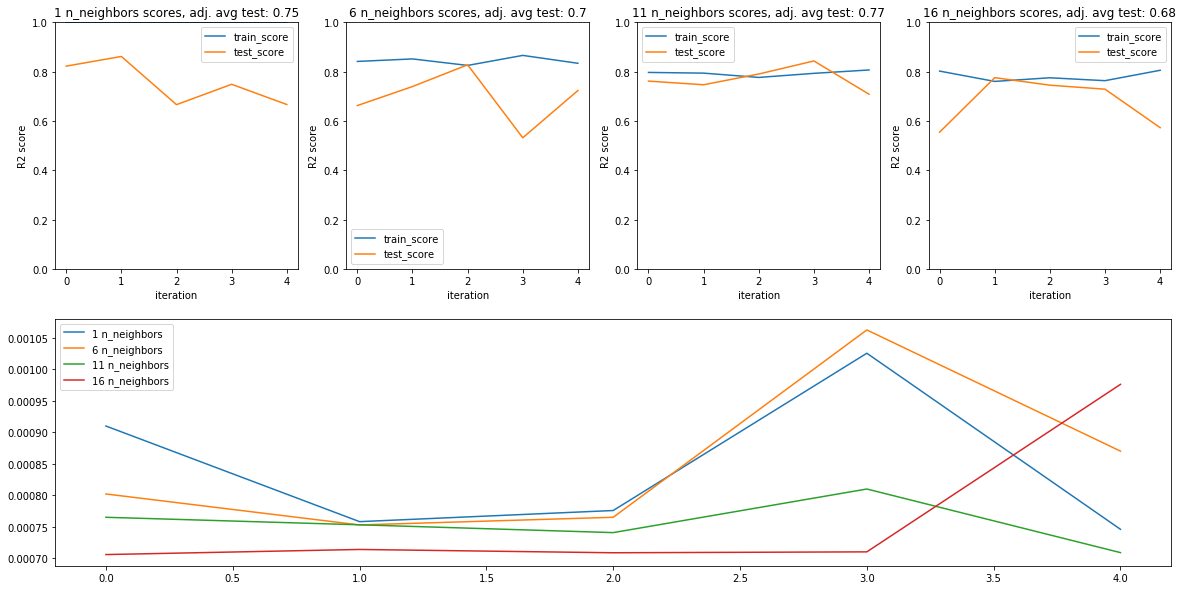

In [7]:
plotCVResults(cv_res, [str(x)+' n_neighbors' for x in range(1,17,5)])